In [2]:
import os
import shutil
import pandas as pd

In [3]:
metadata = pd.read_csv(r"/Users/pedrosantos/Documents 2/Deep Learning/Projeto/rare_species 1/metadata.csv")
metadata

,rare_species_id,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
0,75fd91cb-2881-41cd-88e6-de451e8b60e2,12853737,449393,animalia,mollusca,unionidae,mollusca_unionidae/12853737_449393_eol-full-si...
1,28c508bc-63ff-4e60-9c8f-1934367e1528,20969394,793083,animalia,chordata,geoemydidae,chordata_geoemydidae/20969394_793083_eol-full-...
2,00372441-588c-4af8-9665-29bee20822c0,28895411,319982,animalia,chordata,cryptobranchidae,chordata_cryptobranchidae/28895411_319982_eol-...
3,29cc6040-6af2-49ee-86ec-ab7d89793828,29658536,45510188,animalia,chordata,turdidae,chordata_turdidae/29658536_45510188_eol-full-s...
4,94004bff-3a33-4758-8125-bf72e6e57eab,21252576,7250886,animalia,chordata,indriidae,chordata_indriidae/21252576_7250886_eol-full-s...
...,...,...,...,...,...,...,...
11978,1fa96ea5-32fa-4a25-b8d2-fa99f6e2cb89,29734618,1011315,animalia,chordata,leporidae,chordata_leporidae/29734618_1011315_eol-full-s...
11979,628bf2b4-6ecc-4017-a8e6-4306849e0cfc,29972861,1056842,animalia,chordata,emydidae,chordata_emydidae/29972861_1056842_eol-full-si...
11980,0ecfdec9-b1cd-4d43-96fc-2f8889ec1ad9,30134195,52572074,animalia,chordata,dasyatidae,chordata_dasyatidae/30134195_52572074_eol-full...
11981,27fdb1e9-c5fb-459a-8b6a-6fb222b1c512,9474963,46559139,animalia,chordata,mustelidae,chordata_mustelidae/9474963_46559139_eol-full-...


In [4]:
metadata['family'] = metadata['family'].astype(str)  # Ensure it's a string
metadata['file_path'] = metadata['file_path'].astype(str)  # Ensure path is string

In [5]:
dataset_directory = r"/Users/pedrosantos/Documents 2/Deep Learning/Projeto/rare_species 1"

In [8]:
# Define output directories
output_base = r"/Users/pedrosantos/Documents 2/Deep Learning/Projeto/rare_species 1/dataset_split"
os.makedirs(output_base, exist_ok=True)
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(output_base, split), exist_ok=True)

In [10]:
# Stratified split at image level
from sklearn.model_selection import train_test_split

train_files, temp_files = train_test_split(metadata, test_size=0.3, stratify=metadata['family'], random_state=42)
val_files, test_files = train_test_split(temp_files, test_size=0.5, stratify=temp_files['family'], random_state=42)

In [12]:
def move_files(file_subset, split_name):
    for _, row in file_subset.iterrows():
        src_path = os.path.join(dataset_directory, row['file_path'])  # Construct full path
        dst_path = os.path.join(output_base, split_name, row['file_path'])
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)  # Ensure folder structure
        if os.path.exists(src_path):
            shutil.copy2(src_path, dst_path)
        else:
            print(f"Warning: {src_path} not found.")

# Move images to respective folders
move_files(train_files, 'train')
move_files(val_files, 'val')
move_files(test_files, 'test')

print("Dataset split completed!")


Dataset split completed!


#### Localizing Data

In [6]:
train_path = r"/Users/pedrosantos/Documents 2/Deep Learning/Projeto/rare_species 1/dataset_split/train"
valid_path = r"/Users/pedrosantos/Documents 2/Deep Learning/Projeto/rare_species 1/dataset_split/val"
test_path = r"/Users/pedrosantos/Documents 2/Deep Learning/Projeto/rare_species 1/dataset_split/test"

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

In [8]:
# Define ImageDataGenerator with preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,  # VGG16 preprocessing
    horizontal_flip=True,  # Add basic augmentation
    rotation_range=20
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input  # No augmentation for val/test
)

In [9]:
# Load images from directories
train_batches = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(224, 224),
    batch_size=32,  # Adjust based on memory
    class_mode="categorical",  # Multi-class classification
    shuffle=True
)

val_batches = val_test_datagen.flow_from_directory(
    directory=valid_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False  # No shuffle for validation
)

test_batches = val_test_datagen.flow_from_directory(
    directory=test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False  # No shuffle for testing
)

# Print detected class labels
print(f"Class labels: {train_batches.class_indices}")

Found 8388 images belonging to 202 classes.
Found 1797 images belonging to 202 classes.
Found 1798 images belonging to 202 classes.
Class labels: {'arthropoda_apidae': 0, 'arthropoda_attelabidae': 1, 'arthropoda_carabidae': 2, 'arthropoda_cerambycidae': 3, 'arthropoda_coenagrionidae': 4, 'arthropoda_formicidae': 5, 'arthropoda_gomphidae': 6, 'arthropoda_lucanidae': 7, 'arthropoda_nymphalidae': 8, 'arthropoda_palinuridae': 9, 'arthropoda_papilionidae': 10, 'arthropoda_pisauridae': 11, 'arthropoda_platystictidae': 12, 'arthropoda_pseudophasmatidae': 13, 'arthropoda_tettigoniidae': 14, 'arthropoda_theraphosidae': 15, 'arthropoda_triopsidae': 16, 'chordata_accipitridae': 17, 'chordata_acipenseridae': 18, 'chordata_agamidae': 19, 'chordata_albulidae': 20, 'chordata_alcedinidae': 21, 'chordata_alligatoridae': 22, 'chordata_alopiidae': 23, 'chordata_ambystomatidae': 24, 'chordata_anatidae': 25, 'chordata_anguidae': 26, 'chordata_aotidae': 27, 'chordata_ardeidae': 28, 'chordata_arthroleptidae'

In [10]:
import matplotlib.pyplot as plt

In [11]:
imgs, labels = next(train_batches)

### this function will plot images in the form of a grid with 1 row and 10 columns where images are placed
def plt_images(images_arr):
    fig,axes = plt.subplots(1,10,figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr,axes):
        ax.imshow(img)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..123.74975].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..150.1933].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-122.37711..124.3184].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-94.52282..146.43967].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.12218..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-118.34062..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-120.68..150.86111].
C

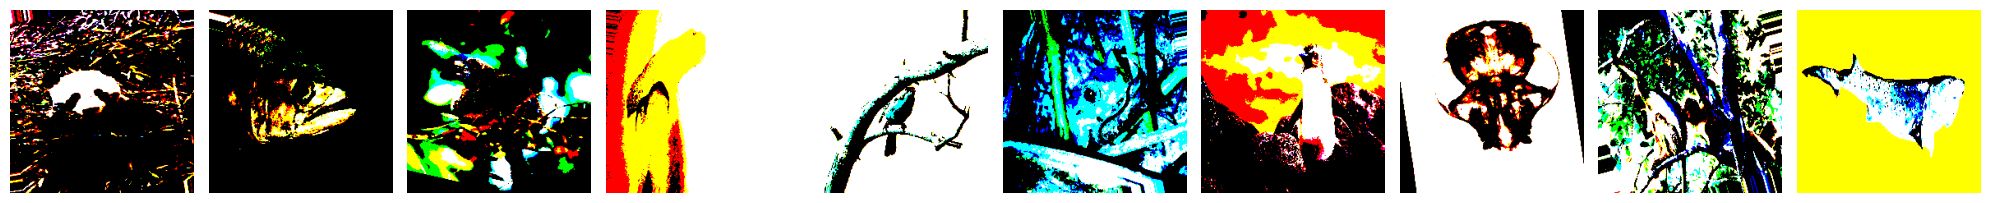

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [12]:
plt_images(imgs)
print(labels)

<hr>

## Training

#### Tensorboard for monitoring

In [13]:
root_logdir = os.path.expanduser("~/logs")  # Stores logs in home directory
os.makedirs(root_logdir, exist_ok=True)

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir,run_id)

In [14]:
run_logdir = get_run_logdir()

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

### Model

In [15]:
model = Sequential([
    Conv2D(filters=3*8, kernel_size=(3,3), activation="relu", padding="same", input_shape=(224,224,3)),
    MaxPooling2D(pool_size=(2,2), strides=2),
    Conv2D(filters=3*16, kernel_size=(3,3), activation="relu", padding="same"),
    MaxPooling2D(pool_size=(2,2), strides=1),
    Conv2D(filters=3*32, kernel_size=(3,3), activation="relu", padding="same"),
    MaxPooling2D(pool_size=(2,2), strides=1),
    Flatten(),
    Dense(units=202, activation="softmax")
])

/opt/anaconda3/envs/DL/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

In [20]:
#model.fit(train_batches, validation_data=val_batches, epochs=50, verbose=2, callbacks=[tensorboard_cb])

In [19]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [21]:
vgg16_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [23]:
for layer in model.layers:
    layer.trainable = False

In [27]:
model.add(Dense((202), activation="softmax"))

In [28]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 202)            │       827,594 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,088,138 (515.32 MB)

 Trainable params: 827,594 (3.16 MB)

 Non-trainable params: 134,260,544 (512.16 MB)

In [29]:
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.fit(train_batches, validation_data=val_batches, epochs=50, verbose=2, callbacks=[tensorboard_cb])

Epoch 1/50


/opt/anaconda3/envs/DL/lib/python3.11/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


263/263 - 998s - 4s/step - accuracy: 0.3913 - loss: 3.5639 - val_accuracy: 0.4969 - val_loss: 2.8872
Epoch 2/50
263/263 - 980s - 4s/step - accuracy: 0.6650 - loss: 1.3629 - val_accuracy: 0.5303 - val_loss: 2.9585
Epoch 3/50
263/263 - 1023s - 4s/step - accuracy: 0.7667 - loss: 0.8774 - val_accuracy: 0.5543 - val_loss: 2.8651
Epoch 4/50
263/263 - 988s - 4s/step - accuracy: 0.8125 - loss: 0.6849 - val_accuracy: 0.5504 - val_loss: 3.0242
Epoch 5/50
263/263 - 1014s - 4s/step - accuracy: 0.8568 - loss: 0.5022 - val_accuracy: 0.5682 - val_loss: 3.0814
Epoch 6/50
263/263 - 954s - 4s/step - accuracy: 0.8722 - loss: 0.4445 - val_accuracy: 0.5804 - val_loss: 3.2107
Epoch 7/50
263/263 - 958s - 4s/step - accuracy: 0.8866 - loss: 0.3788 - val_accuracy: 0.5693 - val_loss: 3.3540
Epoch 8/50
263/263 - 969s - 4s/step - accuracy: 0.8976 - loss: 0.3629 - val_accuracy: 0.5726 - val_loss: 3.5310
Epoch 9/50


In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6007